In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv("kinetic_energy.csv")

#This is our timeseries data; let's just save it into a single series
ke = np.asarray(df['energytotal'])


## The data

This data is from a quantum Monte Carlo simulation, in which we are sampling the wave function. You don't need to know the details of the simulation, only that to compute the energy expectation value, we want to compute the average of the data here. 

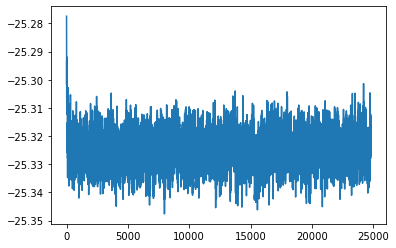

In [65]:
plt.plot(ke)

## Warmup
This run is quite long and the warmup does not take many steps.

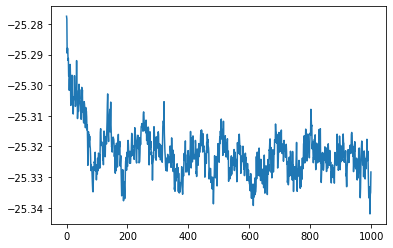

In [66]:
plt.plot(ke[:1000])

Visually it looks like it's converged around 150 steps in.

In [67]:
ke_eq = ke[150:]
Neq = ke.shape[0]


## Autocorrelation

Remember that our error bar formulas (central limit theorem) only apply for: 
1. Independent samples
2. Finite variance

So we'd like to check those two conditions. First autocorrelation using the formulas in the lectures


mean -25.324789779270585 neq 24793
v 3.242159532043789e-05 0.005693996427856088
[0.00579791 0.00786135 0.00743283 0.00705631 0.00527618]
[0.00297308 0.00755615 0.00579791 0.00786135 0.00743283]


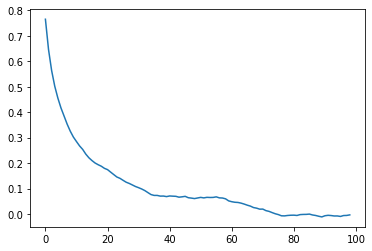

In [70]:
v = np.var(ke_eq)
a = np.mean(ke_eq)
print("mean", a, 'neq', Neq)
d_ke = (ke_eq - a) # delta A
print('v', v, np.std(ke_eq))
# we do some numpy tricks here :) l: cuts off the first l components and :-l cuts off the last l components. 
# Then the coefficients are aligned. This is much faster than explicit loops
cor = [np.sum(d_ke[i:]*d_ke[:-i])/(Neq-i)/v for i in range(1,100)]

## Just to show what this does...you can remove this of course
l=2
print(d_ke[l:][0:5])
print(d_ke[:-1][0:5])
####

plt.plot(cor)


From this we can see that the correlation coefficient goes to zero after about 100 steps. 
We can compute $\kappa$ and we would expect that to be similar (in magnitude). $\kappa$ is really how many steps it takes to get a single independent data point so it should be less than 100.

In [72]:
kappa = 1 + 2.0*np.sum(cor)
print(kappa)

22.448798231987922


## Computing uncertainties

Now we can compute our uncertainties accounting for autocorrelation.

In [74]:
err = np.sqrt(v*kappa/Neq)
print("mean", a , "+/-", err)

mean -25.324789779270585 +/- 0.0001713362267525957


## Bias

Let's now suppose we are interested in $F(E) = e^{-\beta E}$ for some reason (maybe we want to compute Boltzmann factors). To compute the bias and uncertainty in this, we need the derivatives:
$$
\frac{dF}{dE} = -\beta e^{-\beta E}
$$

$$ 
\frac{d^2F}{dE^2} = \beta^2 e^{-\beta E}
$$

Then we can use the formulas in the lecture notes to compute the bias and the error of $F$. 


In [82]:
beta = 0.05 # arbitrary
dfde = -beta*np.exp(-beta*a)
d2fde2 = beta**2 * np.exp(-beta*a)

f_bias = 0.5*d2fde2*err**2
f_err = np.abs(dfde)*err

print('f', np.exp(-beta*a), "bias in f", f_bias, "error in f", f_err)

f 3.5474870832619505 bias in f 1.3017549347583501e-10 error in f 3.0390652564983697e-05


These numbers are fairly small because we have small uncertainties in our calculation. 

## Bootstrap

There are other ways of estimating bias; one is bootstrap, one version of which involves resampling. We generate many instances of the average according to a normal distribution with the

standard deviation 3.05651689519772e-05


<AxesSubplot:ylabel='Density'>

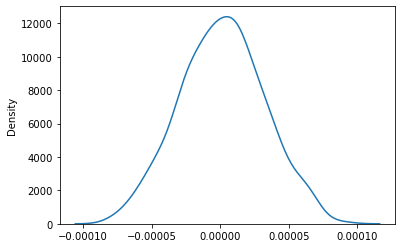

In [84]:
rng = np.random.RandomState() #Random number generator
avgs = np.exp(-beta*rng.normal(a, err, size=500)) - np.exp(-beta*a)
print("standard deviation", np.std(avgs))
sns.kdeplot(avgs)

As expected from the above calculation, because the errors are small here, we see that the nonlinear function doesn't make it TOO far from a Gaussian, and the standard deviation we get from bootstrap is pretty similar to the standard deviation from the analytic estimate.